In [1]:
import sys
import os

import matplotlib.pyplot as plt

from Mala.mala import MALAKernel

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *

In [3]:
D = 10
L = 2 * jnp.pi
h = (2 * jnp.pi) / D
ones_mat = jnp.ones((D + 1, D + 1))
delta_h = compute_second_order_diff(D, h)
init_mean = jnp.zeros(D + 1)
delta = 1e2
gamma = 1 / (2 * np.sqrt(h))

sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

In [4]:
rng_key = random.PRNGKey(0)

ensemble = random.normal(rng_key, shape=(D + 1, 100))

ensemble = init_mean[:, jnp.newaxis] + jnp.dot(sqrt_covar, ensemble)

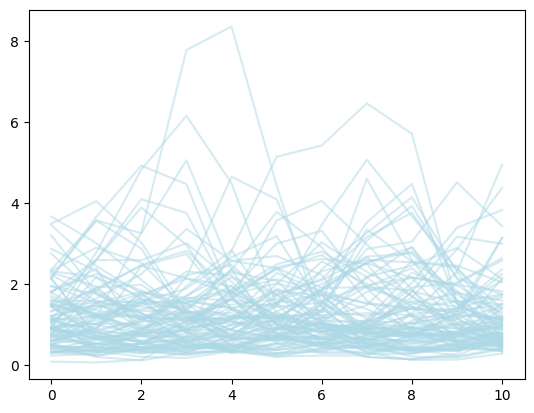

In [5]:
plt.plot(jnp.exp(ensemble), color="lightblue", alpha=0.5)
plt.show()

In [6]:
def run(
    f0,
    g_array,
    plot,
    h,
    dim_parameters,
    dim_observations,
    num_particles,
    noise_level=1e-6,
):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)

    y_true = forward_model.evaluate_single(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    # plt.plot(i_array, f0)
    # plt.plot(i_array, y_true)
    # plt.show()
    ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
    delta_h = compute_second_order_diff(dim_parameters, h)
    init_mean = jnp.zeros(dim_parameters + 1)
    delta = 1e2
    gamma = 1 / (2 * jnp.sqrt(h))

    sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

    prior_cov = sqrt_covar
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=init_mean,
        noise_level=noise_level,
        time_interval=(1, 200, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=0.5,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results

In [7]:
# global parameters
dim_parameters = 100
dim_observations = 100
plot = False
num_particles = 50

noise_levels = [1e-2, 1e-4, 1e-6, 1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [8]:
L = 2 * jnp.pi
h = (2 * jnp.pi) / dim_parameters
x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
f0 = jnp.exp(0.5 * jnp.sin(x_array))
g_array = (
    jnp.exp(-((x_array - L / 2) ** 2) / 10)
    - jnp.exp(-((x_array - L / 2) ** 2) / 10).mean()
)

In [9]:
results_list = []
for noise_level in noise_levels:
    results = run(
        f0,
        g_array,
        plot,
        h,
        dim_parameters,
        dim_observations,
        num_particles,
        noise_level,
    )
    results_list.append(results)

nonlinear
norm ensemble 107.824615
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.196496
nonlinear
norm ensemble 107.824615
norm ensemble 107.824615
norm ensemble 107.824615
norm cross_cov 3.282838
116.04531
norm ensemble 98.63078
norm ensemble 98.63078
norm cross_cov 0.8803768
103.69404
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.040079
nonlinear
norm ensemble 107.824615
norm ensemble 107.824615
norm ensemble 107.824615
norm cross_cov 3.282838
537.1884
norm ensemble 97.606155
norm ensemble 97.606155
norm cross_cov 0.9059586
439.27344
norm ensemble 86.20167
norm ensemble 86.20167
norm cross_cov 0.22142859
321.55734
norm ensemble 80.63966
norm ensemble 80.63966
norm cross_cov 0.07196827
245.03807
norm ensemble 80.90084
norm ensemble 80.90084
norm cross_cov 0.018658789
196.18037
norm ensemble 80.09527
norm ensemble 80.09527
norm cross_cov 0.0050283545
159.36427
converged

Algorithm converged: True
Stopping time: 6
Final residual: 0.000

stopping index 1
stopping index 3
stopping index 7
stopping index 8


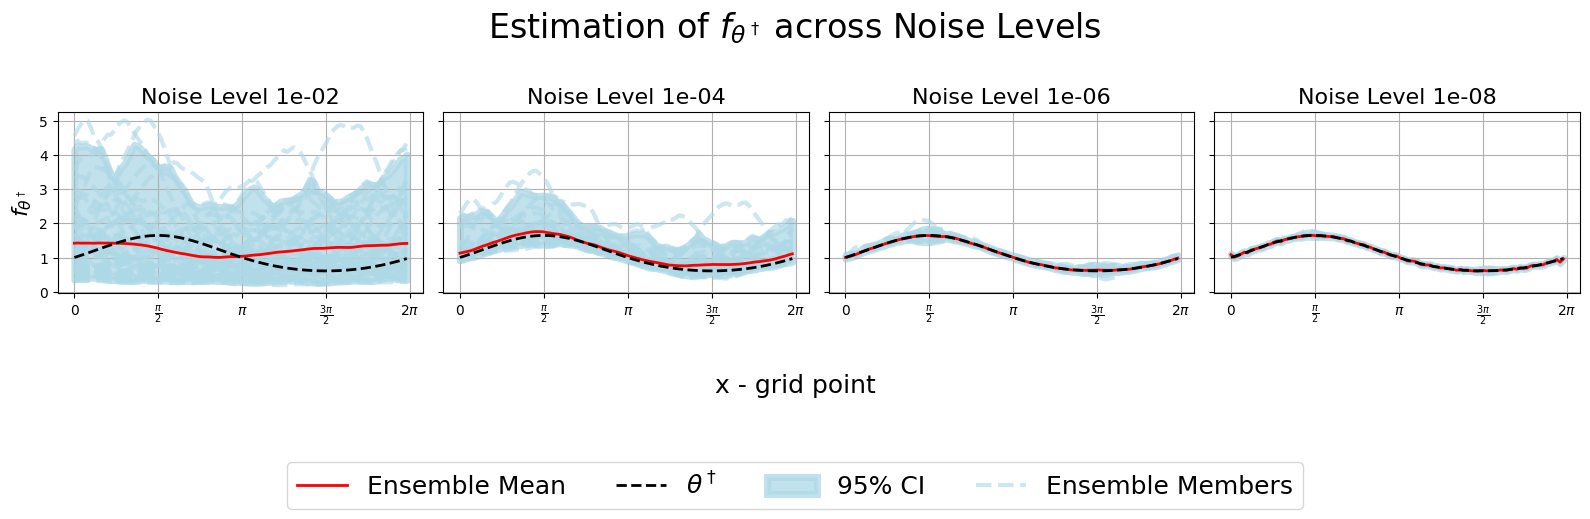

In [22]:
import matplotlib.pyplot as plt

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(results_list):
    ax = axes[col_idx]
    print("stopping index", len(results["ensemble_history"]))
    hat_coefs_f0_ensemble = results["ensemble_history"][-1]

    # Plot individual ensemble members
    ensemble_members_handle = ax.plot(
        x_array,
        hat_coefs_f0_ensemble,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=3,
    )

    # Ensemble mean
    (ensemble_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(hat_coefs_f0_ensemble, axis=1),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )
    mean = jnp.mean(hat_coefs_f0_ensemble, axis=1)
    diff = jnp.linalg.norm(f0 - mean)
    # print(diff)
    # True f0
    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$\theta^\dagger$", "95% CI", "Ensemble Members"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()